## Extract keypoints from the videos using HRNET

* The extracted keypoints are saved in separate pickle files.
* These keypoints are in the ntu-rgbd format, so we can use them with PoseC3D.

In [ ]:
import os

# Define the base directory of your videos and the output directory for pkl files
base_dir = '/home/samer/Desktop/Projects/mmaction2/data/Recorded_Videos'
output_dir = '/home/samer/Desktop/Projects/mmaction2/scripts/skeleton_ann_pkl'
ntu_pose_extraction_script = '/home/samer/Desktop/Projects/mmaction2/tools/data/skeleton/ntu_pose_extraction.py'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Define a mapping for class names to labels
class_to_label = {'normal_shopping': 0, 'shoplifting': 1}

# Loop through each class and video
for class_name in sorted(os.listdir(base_dir)):
    class_dir = os.path.join(base_dir, class_name)
    for sequence in sorted(os.listdir(class_dir)):
        sequence_dir = os.path.join(class_dir, sequence)
        video_file = os.path.join(sequence_dir, 'sequence_video.avi')
        output_pkl = os.path.join(output_dir, f'{class_name}_{sequence}.pkl')
        
        # Set the label based on the class name
        label = class_to_label[class_name]
        
        # Run the extraction script
        os.system(f'python {ntu_pose_extraction_script} {video_file} {output_pkl} --label {label} --skip-postproc')

## Visualize some pickle files to check

Keys in the data: dict_keys(['keypoint', 'keypoint_score', 'frame_dir', 'img_shape', 'original_shape', 'total_frames', 'label'])
Frame dir: sequence_video
Label: 0
Img shape: (480, 640)
Total frames: 699
Keypoint shape: (1, 699, 17, 2)
Keypoint score shape: (1, 699, 17)
Sample keypoint: [[107.013824 148.52197 ]
 [108.08159  145.31868 ]
 [103.810524 146.38644 ]
 [110.217125 145.31868 ]
 [ 98.47169  149.58974 ]
 [118.75926  155.99634 ]
 [ 97.40392  164.53848 ]
 [130.5047   170.94508 ]
 [ 98.47169  183.75829 ]
 [140.1146   186.9616  ]
 [104.87829  200.84256 ]
 [127.3014   189.09712 ]
 [114.48819  193.3682  ]
 [134.77577  210.45247 ]
 [125.16586  212.588   ]
 [139.04683  230.74004 ]
 [132.64023  232.87556 ]]
Sample keypoint score: [0.94357574 0.9624891  0.9678228  0.8643198  0.93478954 0.8821052
 0.84945524 0.8724393  0.8590549  0.8287753  0.8344671  0.75275254
 0.71676743 0.8133187  0.7404719  0.8771887  0.8272256 ]


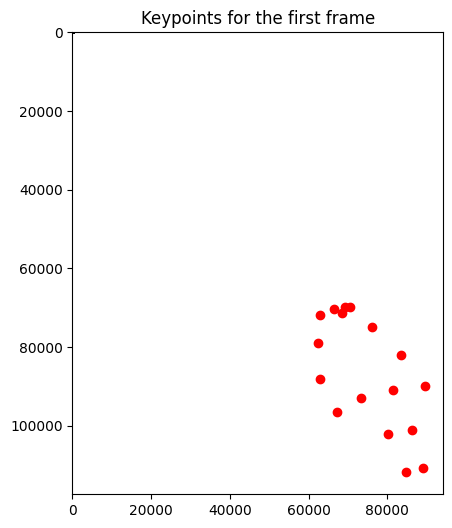

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load the pickle file
file_path = '/home/samer/Desktop/Projects/mmaction2/scripts/skeleton_ann_pkl/normal_shopping_sequence_4.pkl'
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Print the keys in the data
print(f"Keys in the data: {data.keys()}")

# Extract keypoints and other information
keypoints = data['keypoint']
keypoint_scores = data['keypoint_score']
frame_dir = data['frame_dir']
img_shape = data['img_shape']
total_frames = data['total_frames']
label = data['label']

print(f"Frame dir: {frame_dir}")
print(f"Label: {label}")
print(f"Img shape: {img_shape}")
print(f"Total frames: {total_frames}")
print(f"Keypoint shape: {keypoints.shape}")
print(f"Keypoint score shape: {keypoint_scores.shape}")
print(f"Sample keypoint: {keypoints[0, 0]}")
print(f"Sample keypoint score: {keypoint_scores[0, 0]}")

# Visualize the keypoints for the first frame
first_frame_keypoints = keypoints[0, 0]  # (num_keypoints, 2)
plt.figure(figsize=(6, 6))
plt.imshow(np.zeros(img_shape), cmap='gray')  # Create a black background
plt.scatter(first_frame_keypoints[:, 0] * img_shape[1], first_frame_keypoints[:, 1] * img_shape[0], c='r')
plt.title('Keypoints for the first frame')
plt.show()

## Mark the keypoints from a pickle file on its video

In [1]:
import pickle
import cv2
import os

# Load the pickle file
file_path = '/home/samer/Desktop/Projects/mmaction2/scripts/skeleton_ann_pkl/normal_shopping_sequence_4.pkl'
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Extract keypoints and other information
keypoints = data['keypoint']
keypoint_scores = data['keypoint_score']
frame_dir = data['frame_dir']
img_shape = data['img_shape']
original_shape = (480, 640)  # Original video shape
total_frames = data['total_frames']
label = data['label']

# Manually set the correct video path
video_path = '/home/samer/Desktop/Projects/mmaction2/data/Recorded_Videos/normal_shopping/sequence_4/sequence_video.avi'
output_video_path = '/home/samer/Desktop/Projects/mmaction2/data/Skeletons_Visualization/output_video_hrnet.mp4'

# Open video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print(f"Error opening video file: {video_path}")
    exit()

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Ensure the keypoints are scaled correctly back to the original shape
scale_x = original_shape[1] / img_shape[1]
scale_y = original_shape[0] / img_shape[0]
keypoints = keypoints * [scale_x, scale_y]

# Create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

frame_idx = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Draw keypoints on the frame
    for person in range(keypoints.shape[0]):
        for kp_idx in range(keypoints.shape[2]):
            kp = keypoints[person, frame_idx, kp_idx]
            if keypoint_scores[person, frame_idx, kp_idx] > 0.5:  # You can adjust the score threshold
                cv2.circle(frame, (int(kp[0]), int(kp[1])), 3, (0, 255, 0), -1)

    out.write(frame)
    frame_idx += 1

# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()

print(f"Output video saved at {output_video_path}")


Output video saved at /home/samer/Desktop/Projects/mmaction2/data/Skeletons_Visualization/output_video_hrnet.mp4


## Combine pickle files for training

In [1]:
# combine pickle files into a single annotation file
import os
import pickle
from sklearn.model_selection import train_test_split

# Directories containing the PKL files
base_dir = '/home/samer/Desktop/Projects/mmaction2/scripts/skeleton_ann_pkl'
output_file = '/home/samer/Desktop/Projects/mmaction2/scripts/combined_annotations_hrnetv1.pkl'

# # Collect all PKL files
# annotations = []
# for file_name in os.listdir(base_dir):
#     if file_name.endswith('.pkl'):
#         file_path = os.path.join(base_dir, file_name)
#         with open(file_path, 'rb') as f:
#             annotations.append(pickle.load(f))

# Collect all PKL files
annotations = []
for file_name in os.listdir(base_dir):
    if file_name.endswith('.pkl'):
        file_path = os.path.join(base_dir, file_name)
        with open(file_path, 'rb') as f:
            annotation = pickle.load(f)
            # Update frame_dir to preserve directory structure
            if 'frame_dir' in annotation:
                action_sequence = file_name.replace('.pkl', '')  # Assuming file names are like 'normal_shopping_sequence_0.pkl'
                annotation['frame_dir'] = action_sequence
            annotations.append(annotation)
            

# Create train, val, and test splits
train_annotations, test_annotations = train_test_split(annotations, test_size=0.2, random_state=42)
train_annotations, val_annotations = train_test_split(train_annotations, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Update split dictionary
split = {
    'train': [ann['frame_dir'] for ann in train_annotations],
    'val': [ann['frame_dir'] for ann in val_annotations],
    'test': [ann['frame_dir'] for ann in test_annotations]
}

# Combine annotations
new_annotations = train_annotations + val_annotations + test_annotations

# Save the data to a combined pickle file
data = {
    'split': split,
    'annotations': new_annotations
}

with open(output_file, 'wb') as f:
    pickle.dump(data, f)

print(f"Combined annotations saved to {output_file}")

Combined annotations saved to /home/samer/Desktop/Projects/mmaction2/scripts/combined_annotations_hrnetv1.pkl


In [2]:
# Check the splits
import pickle

# Load the annotation pickle file
annotation_file = '/home/samer/Desktop/Projects/mmaction2/scripts/combined_annotations_hrnetv1.pkl'

with open(annotation_file, 'rb') as f:
    data = pickle.load(f)

# Print the paths of videos in each split
print("Training videos:")
for video in data['split']['train']:
    print(video)

print("\nValidation videos:")
for video in data['split']['val']:
    print(video)

print("\nTesting videos:")
for video in data['split']['test']:
    print(video)

Training videos:
shoplifting_sequence_12
normal_shopping_sequence_27
shoplifting_sequence_1
shoplifting_sequence_21
shoplifting_sequence_8
normal_shopping_sequence_20
shoplifting_sequence_6
normal_shopping_sequence_25
shoplifting_sequence_17
shoplifting_sequence_14
normal_shopping_sequence_23
shoplifting_sequence_2
normal_shopping_sequence_12
shoplifting_sequence_3
shoplifting_sequence_23
normal_shopping_sequence_0
shoplifting_sequence_25
normal_shopping_sequence_19
normal_shopping_sequence_16
shoplifting_sequence_22
shoplifting_sequence_29
normal_shopping_sequence_8
normal_shopping_sequence_13
shoplifting_sequence_13
normal_shopping_sequence_11
shoplifting_sequence_10
normal_shopping_sequence_3
normal_shopping_sequence_18
normal_shopping_sequence_9
normal_shopping_sequence_22
normal_shopping_sequence_17
shoplifting_sequence_19
shoplifting_sequence_4
shoplifting_sequence_15
normal_shopping_sequence_15
normal_shopping_sequence_1

Validation videos:
shoplifting_sequence_24
normal_shoppin